In [164]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.losses import MSE,MAE,MAPE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


class simple_TS_analysis:

    def __init__(self,DataFrame,n_train):
        self.DataFrame=DataFrame # our DataFrame or array or pd.series that contain ground truth values
        self.n_train=n_train # number of train split 
        self.DataFrame_Copy=self.DataFrame # Copy of DataFrame
        self.list_first_diff=[] # list that contain our first values of test before differencing
        self.diffed_ans=None # predicted values that were differenced
        self.final_res=None # final result for using in compare function
        self.undiffed_ans=None # predicted values that weren't differenced and didnt need it from start
        self.differenced_num=0 # number of times we did the differencing transformation
        self.n_DataFrame= len(self.DataFrame) # len of our DataFrame


    # we check if our data is stationary
    def is_stationary(self):
        """
        check if DataFrame is stationary or not
        """
        p_value=adfuller(self.DataFrame)[1]
        print('ADF test')
        print('Null Hypothesis: our data isn\'t stationary\nAlternative Hypothesis: our data is stationary')
        print(f'P-value: {p_value}\n')


    # if it wasnt stationary we make it stationary by differencing transform
    # n: The number of times values are differenced. If zero, the input is returned as-is.
    # we do one differencing with n=1, n times
    # we do it in this way because we need first value of test array to be able to reverse transform the transformation
    def differencing(self,n):
        """
        applying differencing transformation.
        * n: number of times we do the differencing
        """
        self.differenced_num=n
        for i in range(n):
            self.list_first_diff.append(self.DataFrame[self.n_train])
            self.DataFrame= np.diff(self.DataFrame,n=1)


    
    # function for reverse transform differencing of predictions
    def reverse_differencing(self):
        '''
        reverse transform the differencing transform to have a meaning full results
        '''
        # check if there was any differencing transform and show proper message if there wasnt any transformation
        if self.differenced_num==0 :
            print('the differencing transform didnt apply on this data yet')

        # since we appended our first values of test to the list_first_diff we need to cumsum in reverse order becuase
        # the first values for older differencings are in left and first values for newer transformations are in right but in iterations we go from
        # left to right but we need newer first values first so we apply iteration in reverse order
        elif self.differenced_num!=0:
            for i in range(self.differenced_num -1 , -1 ,-1):
                self.diffed_ans=np.cumsum([self.list_first_diff[i]] + list(self.diffed_ans)) # we make both of them lists best [a]+[b,c]=[a,b,c] and we cumsum it
        
        return self.diffed_ans



    # plotting ACF
    def plot_ACF(self,n_lags=20):
        """
        plotting ACF plot
        * n_lags: number of lags that ACF plot gonna show in x axis
        """
        plot_acf(self.DataFrame,lags=n_lags)
        plt.show(block=False)



    # plotting ACF
    def plot_PACF(self,n_lags=20):
        """
        plotting PACF plot
        * n_lags: number of lags that PACF plot gonna show in x axis
        """
        plot_pacf(self.DataFrame,lags=n_lags)
        plt.show(block=False)



    # function for applying models and get the predictions
    def Apply_model(self,method,order,window):
        '''
        apply a model and return the prediction
        * mothod: there is only 2 options "MA(q)" or "AR(p)"
        * order: p or q respectively for MA(q) or AR(p). if you choose MA as a method then the order will automatically be q.
        * window: numbers of predictions into future in each step. window must be equal or smaller than order.
        '''
        self.window=window
        if window>order:
            raise ValueError('window value mustn\'t be bigger than order')
        
        if method=='MA':
            predicted_values=[] # list that we put our predictions there
            for i in range(self.n_train,len(self.DataFrame),window): # we train a model on n_train first values and predict window value into future and put it in our list and in next iteration
                model=SARIMAX(endog=self.DataFrame[:i],              # we train a model on n_train + window and predict window value into the future and put it in our list and so on...
                              order=(0 , 0, order),
                              simple_differencing=False
                              )
                
                results=model.fit(disp=False)
                predictions=results.get_prediction(0, i + window -1) # we minus 1 cuz its index and start from 0 
                pred=predictions.predicted_mean[-window:] # select the last window values as predicted window value into the future
                predicted_values.extend(pred) # add those predicted values in our list
            
            if self.differenced_num!=0: # if we did any differencing we make a new variable to apply reverse transformation process
                self.diffed_ans=predicted_values
            else:
                self.undiffed_ans=predicted_values # if we didnt do any differencing we make a new variable to be able to use it in comparing function

            return predicted_values
        
        elif method=='AR': # same as MA process
            predicted_values=[]
            for i in range(self.n_train,len(self.DataFrame),window):
                model=SARIMAX(endog=self.DataFrame[:i],
                              order=(order , 0, 0),
                              simple_differencing=False
                              )
                
                results=model.fit(disp=False)
                predictions=results.get_prediction(0, i + window -1)
                pred=predictions.predicted_mean[-window:]
                predicted_values.extend(pred)

            if self.differenced_num!=0:
                self.diffed_ans=predicted_values
            else:
                self.undiffed_ans=predicted_values

            return predicted_values
        

    def comparing(self,loss_func='mse'):
        '''
        
        '''
        if self.differenced_num!=0: # if we did any differencing then we get the reverse transformed predictions as final result 
            self.final_res=self.diffed_ans 

        else: # if we didnt do any differencing then get the vanilla predictions as final result
            self.final_res=self.undiffed_ans


        # calculating mean baseline model
        # this model says future values are mean of past values
        pred_mean=[] 
        for i in range(self.n_train, self.n_DataFrame, self.window):
            mean = np.mean(self.DataFrame_Copy[:i])
            pred_mean.extend(mean for _ in range(self.window))
        

        # calculating last value baseline model
        # this model says future values are the last value we saw
        pred_last_value = []
        for i in range(self.n_train,  self.n_DataFrame, self.window):
            last_value = self.DataFrame_Copy[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(self.window))


        # since we want to plot and compare our prediction and true values we need them have the same index as test part of dataset
        # so we turn our predictions to dataframes which has the same index as true values
        pred=pd.DataFrame(index=range(self.n_train,self.n_DataFrame),data=self.final_res) # we create a dataframe of our answer so it has index and can be show properly
        mean_pred=pd.DataFrame(index=range(self.n_train,self.n_DataFrame),data=pred_mean) # we do the same like last line but give our mean baseline model data
        last_value_pred=pd.DataFrame(index=range(self.n_train,self.n_DataFrame),data=pred_last_value) # same but we give our last value baseline model data

        # from here to the end we try to plot our comparisons
        fig , [ax1,ax2]= plt.subplots(ncols=2,nrows=1)
        ax1.plot( pred , label='pred')
        ax1.plot( self.DataFrame_Copy[self.n_train:] , label='real')
        ax1.plot( mean_pred , label='mean')
        ax1.plot( last_value_pred , label='last value')
        fig.set_figwidth(10)
        fig.set_figheight(5)
        ax1.title.set_text('Prediction Vs Ground truth values')
        ax2.title.set_text('comparing losses')
        ax1.legend()
        plt.tight_layout()


        # calculating MAE loss and plot the bar plot
        if loss_func == "MAE" or loss_func =="mae":
            mae_res=MAE( y_true=self.DataFrame_Copy[self.n_train:] , y_pred=self.final_res )
            mae_mean_res=MAE( y_true=self.DataFrame_Copy[self.n_train:] , y_pred=pred_mean )
            mae_last_value_res=MAE( y_true=self.DataFrame_Copy[self.n_train:] , y_pred=pred_last_value )
            ax2.bar(['MAE for model','MAE mean','MAE last value'],[ mae_res , mae_mean_res , mae_last_value_res ] , color=['orchid' , 'mediumseagreen' , 'orange'])
            plt.show()
        
        # calculating MSE loss and plot the bar plot
        elif loss_func == "MSE" or loss_func == "mse":
            mse_res=MSE( y_true=self.DataFrame_Copy[self.n_train:] , y_pred=pred_mean )
            mse_mean_res=MSE( y_true=self.DataFrame_Copy[self.n_train:] , y_pred=pred_mean )
            mse_last_value_res=MSE( y_true=self.DataFrame_Copy[self.n_train:] , y_pred=pred_last_value )
            ax2.bar(['MSE for model','MSE mean','MSE last value'],[ mse_res , mse_mean_res , mse_last_value_res ] , color=['orchid' , 'mediumseagreen' , 'orange'])
            plt.show()

        # calculating MAPE loss and plot the bar plot
        elif loss_func == 'MAPE' or loss_func == 'mape':
            mape_res=MAPE( y_true=self.DataFrame_Copy[self.n_train:] , y_pred=pred_mean )
            mape_mean_res=MAPE( y_true=self.DataFrame_Copy[self.n_train:] , y_pred=pred_mean )
            mape_last_value_res=MAPE( y_true=self.DataFrame_Copy[self.n_train:] , y_pred=pred_last_value )
            ax2.bar(['MAPE for model','MAPE mean','MAPE last value'],[ mape_res , mape_mean_res , mape_last_value_res ] , color=['orchid' , 'mediumseagreen' , 'orange'])
            plt.show()




In [165]:
df=pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/widget_sales.csv')

In [166]:
a=simple_TS_analysis(df['widget_sales'],n_train=400)
a.differencing(n=1)
a.Apply_model(method='MA',order=1,window=1)
a.reverse_differencing()

array([67.87700501, 66.74572798, 66.38257906, 65.93557326, 66.15490218,
       65.72478768, 66.17911181, 65.42903401, 65.31542917, 65.16844485,
       65.66624385, 66.15470971, 65.59255192, 64.37474245, 64.9078425 ,
       65.24314883, 64.96709725, 65.82949364, 66.12160048, 67.12370276,
       67.23454455, 68.855082  , 70.23319303, 70.62805904, 71.23635865,
       71.81570017, 72.96728779, 72.48939875, 72.9765654 , 73.59785925,
       72.7510137 , 71.63928343, 69.88495447, 69.39422319, 69.64125172,
       70.91155002, 71.17003594, 72.48460378, 71.65116361, 70.52563707,
       69.91348043, 70.21674522, 70.21189044, 68.83085531, 68.42659714,
       67.30746073, 67.71697897, 67.83431353, 67.46671441, 66.85018187,
       66.0200304 , 65.78205501, 66.3553552 , 65.85321902, 66.13637755,
       65.67920032, 65.21740737, 64.85540167, 64.15082658, 63.58184084,
       62.574715  , 63.78145924, 63.94672638, 63.77637235, 63.61212533,
       63.63631352, 63.43903755, 63.84367898, 64.43067462, 64.25

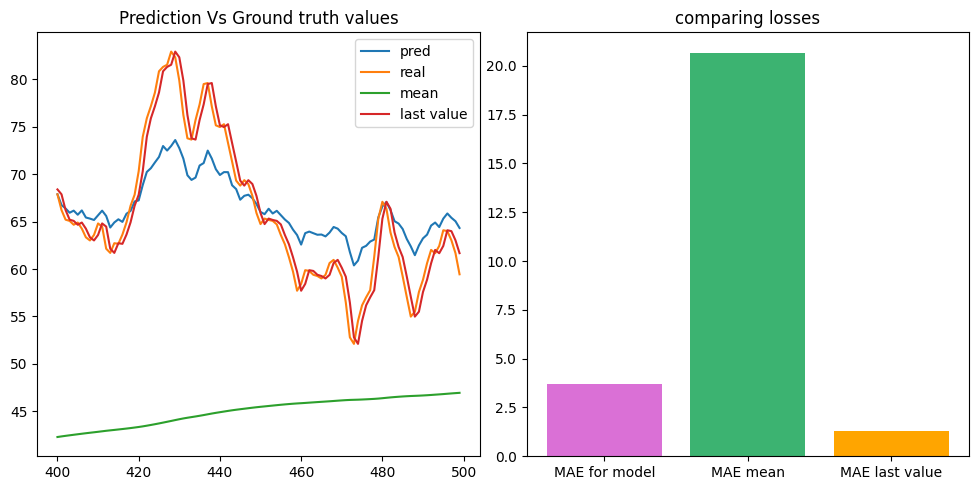

In [167]:
a.comparing(loss_func='mae')